# Tarea 4


## Caracteristicas

### Limones

1. distancia al centroide de cada punto no varia mucho con respecto a la distancia promedio de todos los pixeles al centroide
2. circular/ovalado
3. diametro 1 circulo hough > x numero definido por el diametro de la arandela, es decir mucho mayor al diametro de la arandela
4. gran cantidad de pixeles

### Arandelas

1. circular
2. centro con pocos pixeles
3. pocos pixeles
4. l y h muy pequeños
5. centroide es de un valor diferente de los pixeles del objeto

### Clavos

1. largos
2. brillantes
3. cabeza larga
4. distancia al centroide de varios puntos varia mucho con respecto a la distancia promedio de todos los pixeles al centroide
5. delgados

### Expander

1. largo, menos largo que un clavo
2. delgado, mas ancho que el clavo
3. puede tener patitas
4. 


### Prensa

1. similar en largo que expander, menos que clavo
2. simitria a lo largo
3. corte transversal una mitad mas ancha que la otra
4. 

In [89]:
#Importar las librerías por utilizar
import os
import numpy as np
from skimage import io
from skimage.transform import resize, probabilistic_hough_line,hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.draw import circle_perimeter
from skimage import exposure
from scipy import ndimage
from skimage.morphology import disk
from skimage.morphology import (erosion, dilation, opening, closing)
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches
import math

In [2]:
#Obtener la direccion de las imagenes
path = os.getcwd()

folder = 'MUESTRAS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_fotos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    foto = io.imread(file_path)
    lista_fotos.append(foto)

Análisis de las Imágenes

Antes de buscar una solución al problema descrito es vital realizar las operaciones de preprocesado que permitan manipular y realizar la clasificación de la mejor manera posible. El primer paso es una evaluación general de las imagenes mediante un histograma y la distribución acumulativa, mediante las funciones np.histogram y skimage.exposure.cumulative_distribution

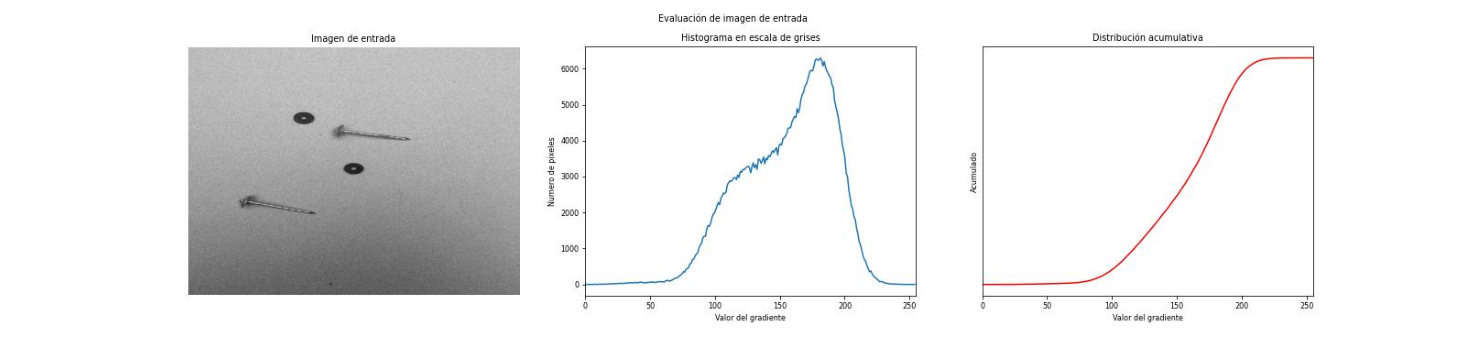

In [3]:
file_path = os.path.join(path , 'HIST5.jpg')
HIST = io.imread(file_path)
plt.figure(figsize = (26,8))
plt.imshow(HIST,cmap='gray')
plt.axis('off')
plt.show()

Como se puede apreciar en el histograma, la imagen de entrada puede mejorar su contraste, para esto se tienen varias opciones que ofrece scikit-image: stretching, ecualización y ecualización adaptativa. Los resultados se muestran a continuación:

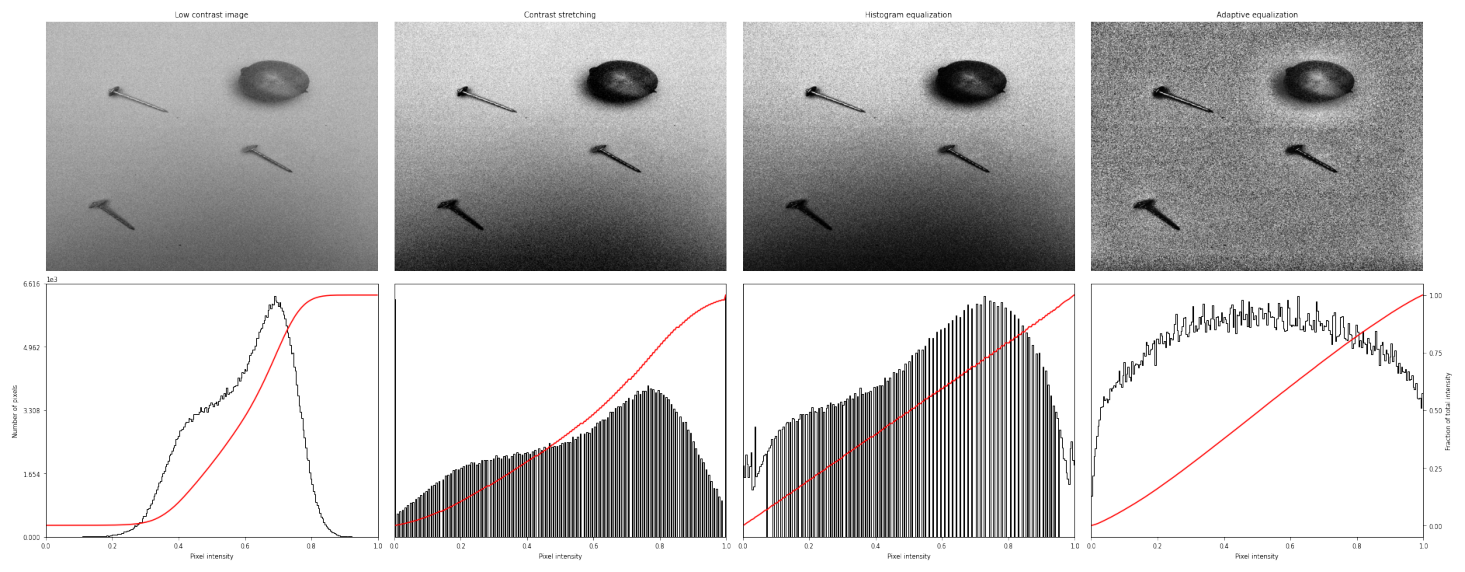

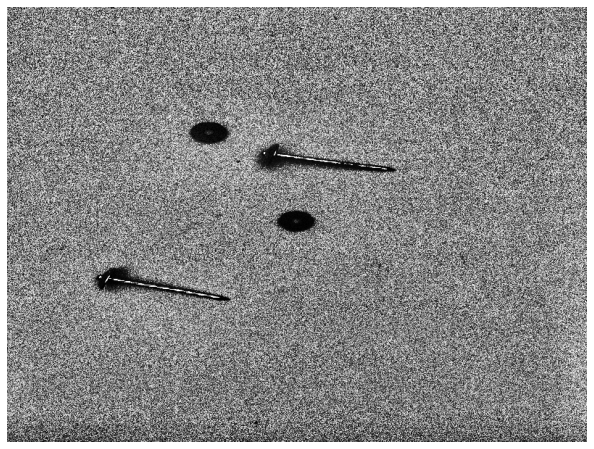

In [4]:
# https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html
file_path = os.path.join(path , 'EQ_3.png')
TYPES_EQUA = io.imread(file_path)
plt.figure(figsize = (26,13))
plt.imshow(TYPES_EQUA,cmap='gray')
plt.axis('off')
plt.show()
index=5
EQUA = exposure.equalize_adapthist(lista_fotos[index], clip_limit=0.03)
plt.figure(figsize = (26,8))
plt.imshow(EQUA,cmap='gray')
plt.axis('off')
plt.show()

Con la ecualización adaptativa se reducen las sombras en la parte inferior de la imagen y se obtiene máximo contraste, por lo tanto se escoge esta función para mejorar el contraste. Cabe resaltar que los objetos ahora se ven mucho mejor que la imagen original. Ahora lo que sigue es tratar de reducir el ruido lo más posible sin perder detalle de los bordes, para esto se utiliza la función skimage.filters.gaussian que permite reducir el ruido de tipo gaussiano, y mediante operaciones aritméticas simples se puede recuperar los bordes. Además se tendrán rellenos más suavizados de forma que a la hora de obtener los objetos (binarización) se reduce la aparición de estos en la imagen
thresh=0.3

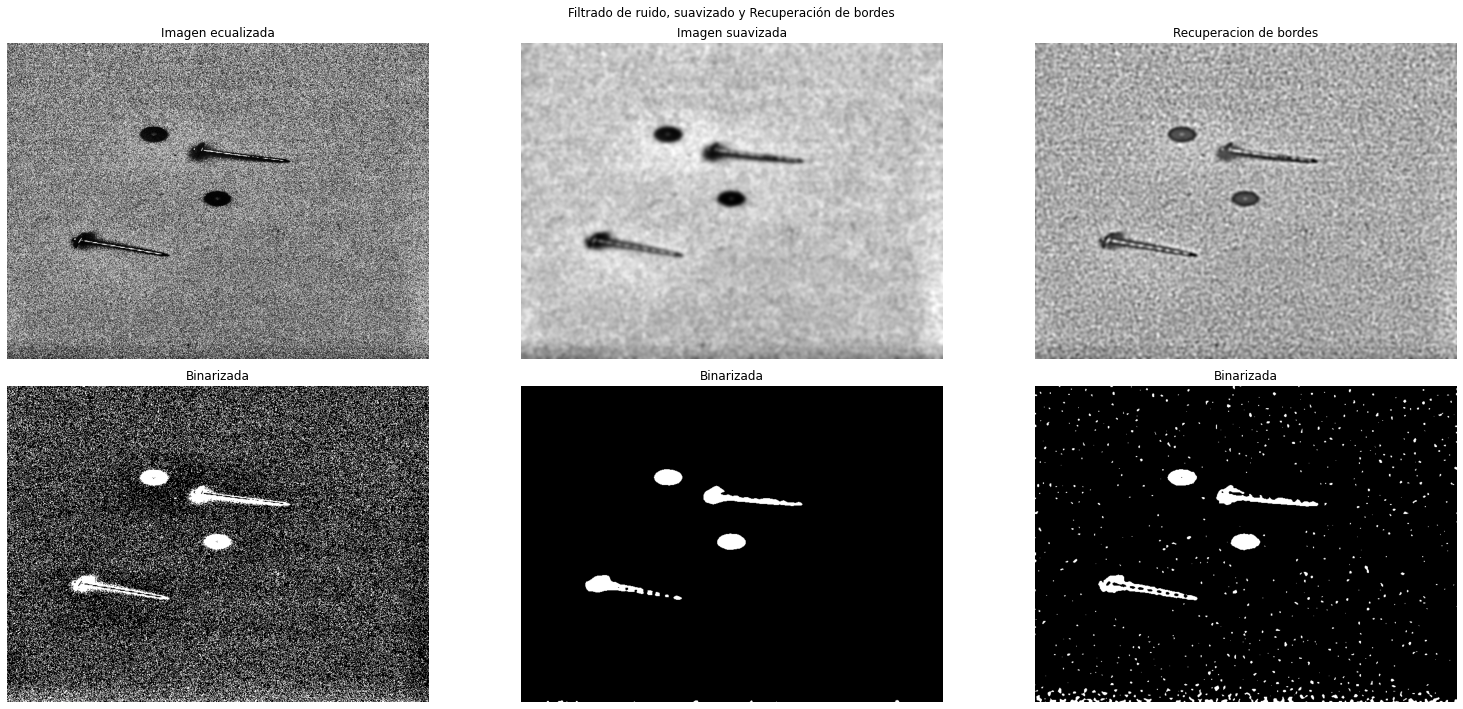

In [5]:
thresh=0.3

f = EQUA
binary_f = f > thresh
binary_f = ~binary_f

blurred_f = ndimage.gaussian_filter(f, 3)
binary_blurred_f = blurred_f > thresh
binary_blurred_f = ~binary_blurred_f

filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
alpha = 40
sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)
binary_sharpened = sharpened > thresh
binary_sharpened = ~binary_sharpened

fig1, axs = plt.subplots(2,3,figsize=(22,10))
fig1.suptitle('Filtrado de ruido, suavizado y Recuperación de bordes')

axs[0,0].set_title("Imagen ecualizada")
axs[0,0].imshow(f, cmap=plt.cm.gray)
axs[0,0].set_axis_off()
axs[1,0].set_title("Binarizada")
axs[1,0].imshow(binary_f, cmap=plt.cm.gray)
axs[1,0].set_axis_off()

axs[0,1].set_title("Imagen suavizada")
axs[0,1].imshow(blurred_f, cmap=plt.cm.gray)
axs[0,1].set_axis_off()
axs[1,1].set_title("Binarizada")
axs[1,1].imshow(binary_blurred_f, cmap=plt.cm.gray)
axs[1,1].set_axis_off()

axs[0,2].set_title("Recuperacion de bordes")
axs[0,2].imshow(sharpened, cmap=plt.cm.gray)
axs[0,2].set_axis_off()
axs[1,2].set_title("Binarizada")
axs[1,2].imshow(binary_sharpened, cmap=plt.cm.gray)
axs[1,2].set_axis_off()

plt.tight_layout()
plt.show()

Como se aprecia en la imagen. La imagen ecualizada queda con mucho ruido luego de la binarización. Con el filtro gaussiano, el ruido se elimina, pero los objetos pierden algunas características vitales (principalmente los más pequeños y delgados); Al realizar la recuperación de bordes antes de la binarización, las características de los objetos se mantienen más (punto intermedio entre los dos). Ahora bien, se puede aplicar un filtro de mediana para eleiminar los pequeños puntos restantes del ruido. Posterior a ello, se realiza una operación de clausura, de forma que los objetos más grandes se unan en uno solo en caso de que no lo estén. A pesar de que la imagen borrosa binarizada pierde ciertos detalles, es la que mejor características de ruido presenta, por lo tanto, se utilizará, de ahora en adelante. Posterior al filtrado gaussiano, se puede realizar una clausura para recuperar parte de los detalles:

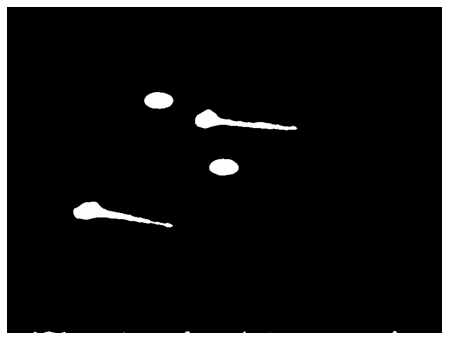

In [6]:
footprint = disk(18)
limp = closing(binary_blurred_f,footprint)*255
plt.figure(figsize = (12,6))
plt.imshow(limp,cmap='gray')
#plt.imshow(limp,cmap='gray')
plt.axis('off')
plt.show()

In [7]:
print(np.max(limp))

255


In [8]:
N_SEEDS = 1500

# 8-vecindad
VECINDAD = [
    (-1,-1), (-1, 0), (-1, 1),
    ( 0,-1),          ( 0, 1),
    ( 1,-1), ( 1, 0), ( 1, 1)]


In [9]:
def generate_seeds(img):
    #shape = y,x
    shape = img.shape
    #cada semilla se guarda como x,y
    seeds = []
    for i in range(N_SEEDS):
        #punto en x
        x = np.random.randint(0,shape[1])
        #punto en y
        y = np.random.randint(0,shape[0])
        if img[y][x] == 255:
            seeds.append((x,y))
    return seeds


def region_growth1(seed, bin_img, visitado, out_img = np.zeros(shape=(320,240,3), dtype=np.uint8)):  
    h, w = bin_img.shape
    region = [seed]
    # Crecimiento de la región
    while len(region):
        seed = region.pop(0)
        x = seed[0]
        y = seed[1]
        # Marca la semilla como visitada
        visitado[y][x] = 1
        for vecino in VECINDAD:
            cur_x = x + vecino[0]
            cur_y = y + vecino[1]
            # limites de la imagen
            if cur_x <0 or cur_y<0 or cur_x >= w or cur_y >=h :
                continue
            # crea nueva semilla si el pixel actual es igual a la semilla
            # y si aun no está visitado, marca pixel actual como visitado
            if (not visitado[cur_y][cur_x]) and (bin_img[cur_y][cur_x]==bin_img[y][x]):
                out_img[cur_y][cur_x] = True
                visitado[cur_y][cur_x] = 1
                region.append((cur_x,cur_y))
    return out_img

def region_growth(seed, img, visitado):
    h, w = img.shape
    out_img = np.zeros(img.shape, dtype=np.uint8)
    region = [seed]
    # Crecimiento de la región
    while len(region):
        seed = region.pop(0)
        x = seed[0]
        y = seed[1]
        # Marca la semilla como visitada
        visitado[y][x] = 1
        for vecino in VECINDAD:
            cur_x = x + vecino[0]
            cur_y = y + vecino[1]
            # limites de la imagen
            if cur_x <0 or cur_y<0 or cur_x >= w or cur_y >=h :
                continue
            # crea nueva semilla si el pixel actual es similar a la semilla
            # y si aun no está visitado, marca pixel actual como visitado
            if (not visitado[cur_y][cur_x]) and (img[cur_y][cur_x] == img[y][x]):
                out_img[cur_y][cur_x] = True
                visitado[cur_y][cur_x] = 1
                region.append((cur_x,cur_y))
    return out_img

In [10]:
semillas = generate_seeds(limp)
print(semillas)
print(len(semillas))

[(124, 379), (172, 379), (262, 182), (381, 212), (280, 175), (296, 181), (210, 387), (365, 194), (480, 219), (164, 360), (367, 201), (374, 207), (442, 218), (389, 215), (369, 217), (360, 202), (526, 220), (257, 166), (130, 382), (134, 381), (153, 386), (227, 392)]
22


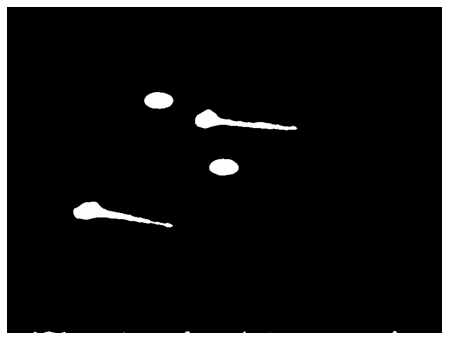

1
2515


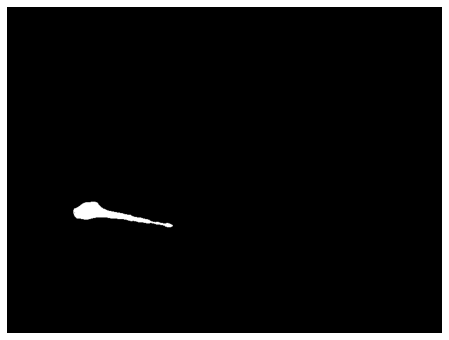

1
1291


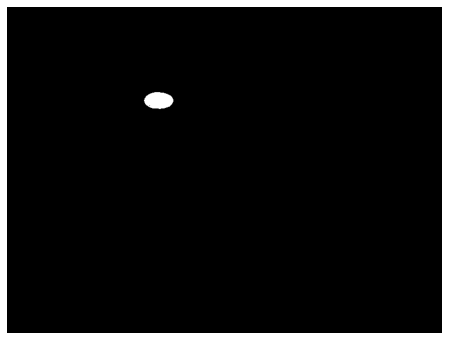

1
2456


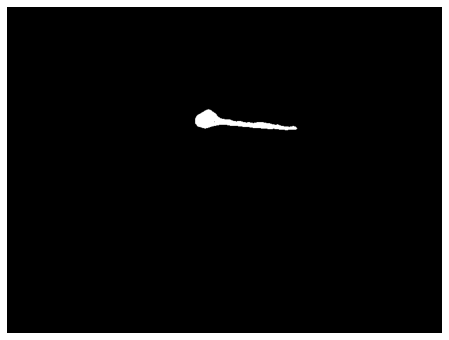

In [11]:
img = limp
img_shape = img.shape
regions = []
visitado = np.zeros((img_shape[0],img_shape[1],1), dtype=np.uint8)
for i in semillas:
        reg_temp = region_growth(i,img,visitado)
        if np.max(reg_temp) > 0:
                regions.append(reg_temp)
plt.figure(figsize = (12,6))
plt.imshow(img,cmap='gray')
#plt.imshow(limp,cmap='gray')
plt.axis('off')
plt.show()
for region in regions:
        print(np.max(region))
        print(np.sum(region))
        plt.figure(figsize = (12,6))
        plt.imshow(region,cmap='gray')
        #plt.imshow(limp,cmap='gray')
        plt.axis('off')
        plt.show()

In [12]:
def cleanse(regions):
    objects = []
    for region in regions:
        if np.max(region) > 0 and np.sum(region) >= 1000:
            objects.append(region)
    return objects

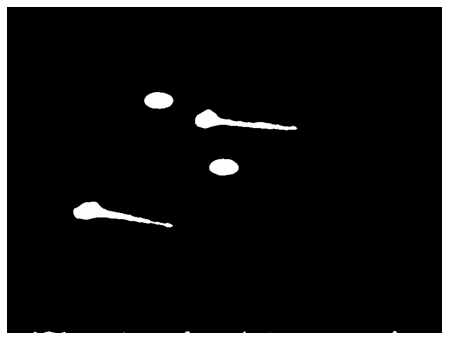

1
1303


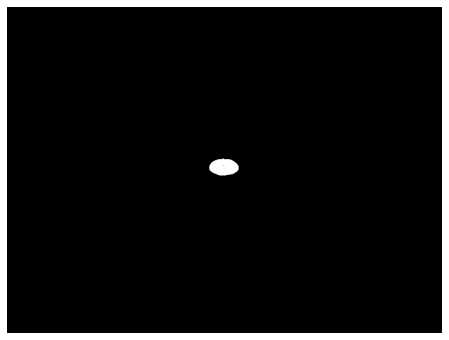

1
2515


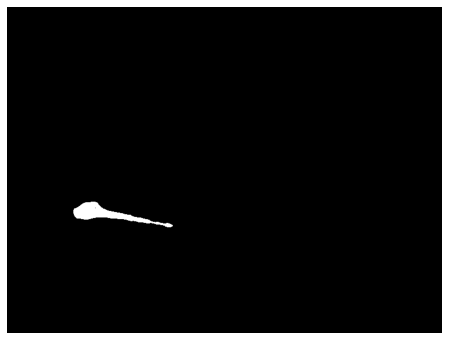

1
2456


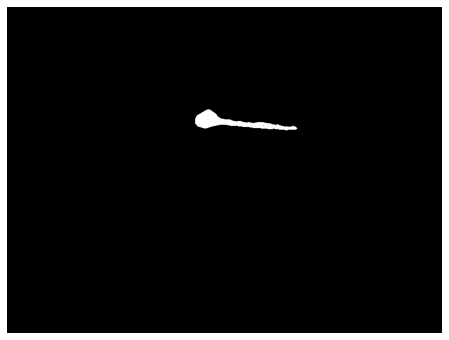

1
1291


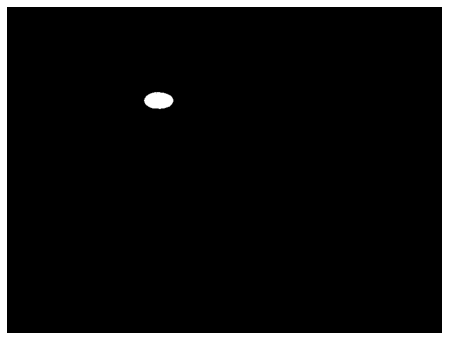

In [13]:
file_path = os.path.join(path , 'EQ_3.png')
TYPES_EQUA = io.imread(file_path)
index=5
EQUA = exposure.equalize_adapthist(lista_fotos[index], clip_limit=0.03)
thresh=0.3

f = EQUA
binary_f = f > thresh
binary_f = ~binary_f

blurred_f = ndimage.gaussian_filter(f, 3)
binary_blurred_f = blurred_f > thresh
binary_blurred_f = ~binary_blurred_f
footprint = disk(18)
limp = closing(binary_blurred_f,footprint)*255
img = limp
semillas = generate_seeds(img)
img_shape = img.shape
regions = []
visitado = np.zeros((img_shape[0],img_shape[1],1), dtype=np.uint8)
for i in semillas:
        regions.append(region_growth(i,img,visitado))
regions = cleanse(regions)
plt.figure(figsize = (12,6))
plt.imshow(img,cmap='gray')
#plt.imshow(limp,cmap='gray')
plt.axis('off')
plt.show()
for region in regions:
        print(np.max(region))
        print(np.sum(region))
        plt.figure(figsize = (12,6))
        plt.imshow(region,cmap='gray')
        #plt.imshow(limp,cmap='gray')
        plt.axis('off')
        plt.show()

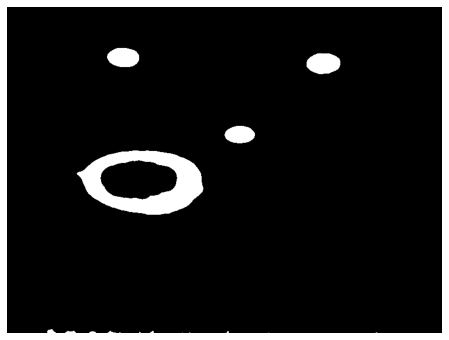

1
12998


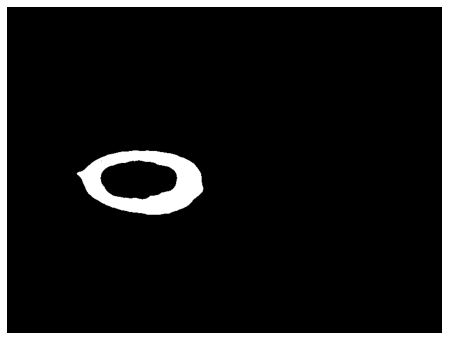

1
1668


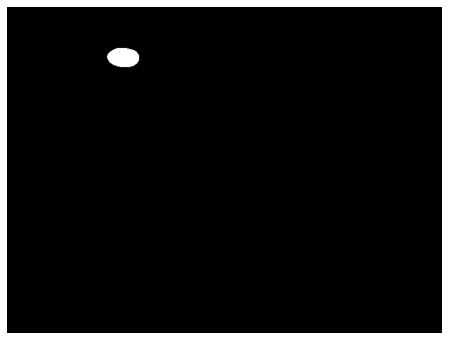

1
1888


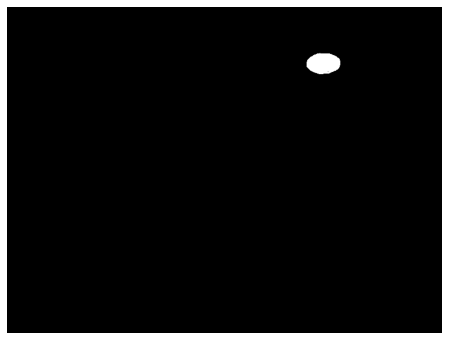

1
1399


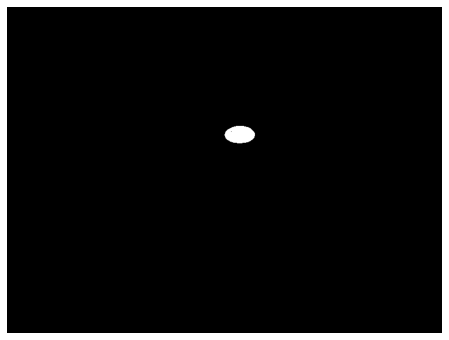

In [14]:
file_path = os.path.join(path , 'EQ_3.png')
TYPES_EQUA = io.imread(file_path)
index=8
EQUA = exposure.equalize_adapthist(lista_fotos[index], clip_limit=0.03)
thresh=0.3

f = EQUA
binary_f = f > thresh
binary_f = ~binary_f

blurred_f = ndimage.gaussian_filter(f, 3)
binary_blurred_f = blurred_f > thresh
binary_blurred_f = ~binary_blurred_f
footprint = disk(18)
limp = closing(binary_blurred_f,footprint)*255
img = limp
semillas = generate_seeds(img)
img_shape = img.shape
regions = []
visitado = np.zeros((img_shape[0],img_shape[1],1), dtype=np.uint8)
for i in semillas:
        regions.append(region_growth(i,img,visitado))
regions = cleanse(regions)
plt.figure(figsize = (12,6))
plt.imshow(img,cmap='gray')
#plt.imshow(limp,cmap='gray')
plt.axis('off')
plt.show()
for region in regions:
        print(np.max(region))
        print(np.sum(region))
        plt.figure(figsize = (12,6))
        plt.imshow(region,cmap='gray')
        #plt.imshow(limp,cmap='gray')
        plt.axis('off')
        plt.show()

In [15]:
def region_growth_pixels(seed, img, visitado):
    h, w = img.shape
    out_img = np.zeros(img.shape, dtype=np.uint8)
    out_img_pxls = []
    region = [seed]
    # Crecimiento de la región
    while len(region):
        seed = region.pop(0)
        x = seed[0]
        y = seed[1]
        # Marca la semilla como visitada
        visitado[y][x] = 1
        for vecino in VECINDAD:
            if (x,y) not in out_img_pxls:
                out_img_pxls.append((x,y))
            cur_x = x + vecino[0]
            cur_y = y + vecino[1]
            # limites de la imagen
            if cur_x <0 or cur_y<0 or cur_x >= w or cur_y >=h :
                continue
            # crea nueva semilla si el pixel actual es similar a la semilla
            # y si aun no está visitado, marca pixel actual como visitado
            if (not visitado[cur_y][cur_x]) and (img[cur_y][cur_x] == img[y][x]):
                out_img[cur_y][cur_x] = True
                visitado[cur_y][cur_x] = 1
                region.append((cur_x,cur_y))
                out_img_pxls.append((cur_x,cur_y))

    return out_img,out_img_pxls

In [16]:
def cleanse_regs(regions,pixels):
    objects = []
    objects_pxls = []
    for i in range(len(regions)):
        region = regions[i]
        if np.max(region) > 0 and np.sum(region) >= 1000:
            objects.append(region)
            objects_pxls.append(pixels[i])
    return objects, objects_pxls

In [17]:
file_path = os.path.join(path , 'EQ_3.png')
TYPES_EQUA = io.imread(file_path)
index=8
EQUA = exposure.equalize_adapthist(lista_fotos[index], clip_limit=0.03)
thresh=0.3

f = EQUA
binary_f = f > thresh
binary_f = ~binary_f

blurred_f = ndimage.gaussian_filter(f, 3)
binary_blurred_f = blurred_f > thresh
binary_blurred_f = ~binary_blurred_f
footprint = disk(18)
limp = closing(binary_blurred_f,footprint)*255
img = limp
semillas = generate_seeds(img)
img_shape = img.shape
regions = []
regions_pxls = []
visitado = np.zeros((img_shape[0],img_shape[1],1), dtype=np.uint8)
for i in semillas:
        out_reg, out_pxls = region_growth_pixels(i,img,visitado)
        regions.append(out_reg)
        regions_pxls.append(out_pxls)
regions,regions_pxls = cleanse_regs(regions, regions_pxls)

In [18]:
print(regions_pxls[0])

[(313, 277), (312, 276), (312, 277), (312, 278), (313, 276), (313, 278), (314, 276), (314, 277), (314, 278), (311, 275), (311, 276), (311, 277), (312, 275), (313, 275), (311, 278), (311, 279), (312, 279), (313, 279), (314, 275), (314, 279), (315, 275), (315, 276), (315, 277), (315, 278), (315, 279), (310, 274), (310, 275), (310, 276), (311, 274), (312, 274), (310, 277), (310, 278), (313, 274), (310, 279), (310, 280), (311, 280), (312, 280), (313, 280), (314, 280), (315, 280), (316, 276), (316, 277), (316, 278), (316, 279), (316, 280), (309, 273), (309, 274), (309, 275), (310, 273), (311, 273), (309, 276), (309, 277), (309, 278), (309, 279), (309, 280), (309, 281), (310, 281), (311, 281), (312, 281), (313, 281), (314, 281), (315, 281), (316, 281), (317, 276), (317, 277), (317, 278), (317, 279), (317, 280), (317, 281), (308, 272), (308, 273), (308, 274), (308, 275), (308, 276), (308, 277), (308, 278), (308, 279), (308, 280), (308, 281), (308, 282), (309, 282), (310, 282), (311, 282), (31

In [19]:
def centroides_obj(puntos):
    kmeans = KMeans(n_clusters=1, random_state=0).fit(puntos)
    colores = kmeans.cluster_centers_
    return colores

In [20]:
centroides = []
for pixeles in regions_pxls:
    centro_obj = centroides_obj(pixeles)
    print(centro_obj[0])
    centroides.append((centro_obj[0][0],centro_obj[0][1]))
print(centroides)

[255.77729056 324.36895146]
[213.68484122  94.02276812]
[581.52408682 105.06140815]
[427.72285714 235.55214286]
[(255.777290560812, 324.36895145780466), (213.6848412222888, 94.02276812462553), (581.5240868184225, 105.0614081524616), (427.7228571428571, 235.55214285714288)]


(600, 800)
255
255


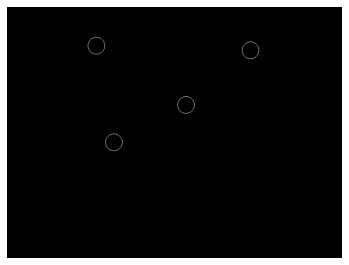

In [21]:
SEEDS=centroides
print(img_shape)
plt.figure(figsize = (6,8))
seeds_img = np.zeros((img_shape[0],img_shape[1]), dtype=np.uint32)
for seed in SEEDS:
    rr, cc = circle_perimeter(np.uint16(seed[1]), np.uint16(seed[0]), 20)
    seeds_img[rr,cc] = 255
print(np.max(limp))
print(np.max(seeds_img))

plt.imshow(limp, cmap = "gray")
plt.imshow(seeds_img, cmap = "gray")
plt.axis('off')
plt.show()

Eliminar ruido de los bordes

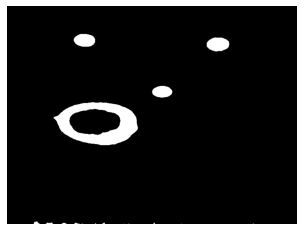

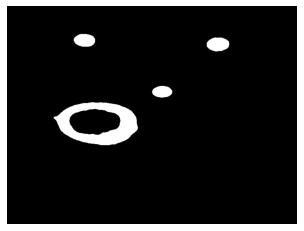

In [40]:
no_borders = clear_border(limp)
plt.imshow(limp, cmap = "gray")
plt.axis('off')
plt.show()
plt.imshow(no_borders, cmap = "gray")
plt.axis('off')
plt.show()

In [24]:
segmented, num_segments = label(no_borders,return_num = True,connectivity= None)

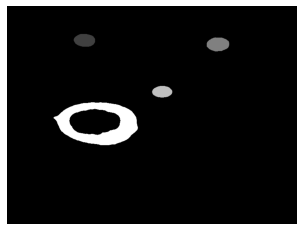

In [25]:
plt.imshow(segmented, cmap = "gray")
plt.axis('off')
plt.show()

Obtener caracteristicas de las regiones con regionprops

In [27]:
props = regionprops(segmented)

[(255.777290560812, 324.36895145780466), (213.6848412222888, 94.02276812462553), (581.5240868184225, 105.0614081524616), (427.7228571428571, 235.55214285714288)]
[(94.02276812462553, 213.68484122228878), (105.06140815246162, 581.5240868184225), (235.55214285714285, 427.72285714285715), (324.3689514578044, 255.77729056081236)]
(600, 800)
(600, 800)
255
255


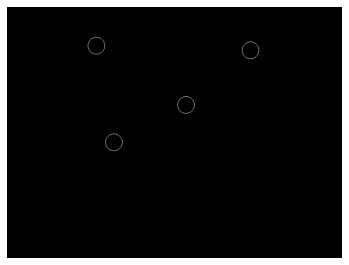

In [34]:
region_locations = []
for i in range(num_segments):   
    centroid = props[i]["centroid"]
    region_locations.append(centroid)


SEEDS=region_locations
print(centroides)
print (region_locations)
print(img_shape)
print(segmented.shape)

plt.figure(figsize = (6,8))
seeds_img = np.zeros((img_shape[0],img_shape[1]), dtype=np.uint32)
for seed in SEEDS:
    rr, cc = circle_perimeter(np.uint16(seed[0]), np.uint16(seed[1]), 20)
    seeds_img[rr,cc] = 255
print(np.max(limp))
print(np.max(seeds_img))

plt.imshow(limp, cmap = "gray")
plt.imshow(seeds_img, cmap = "gray")
plt.axis('off')
plt.show()

In [35]:
for i in range(num_segments):   
    centroid = props[i]["area"]
    print(centroid)

1669
1889
1400
12999


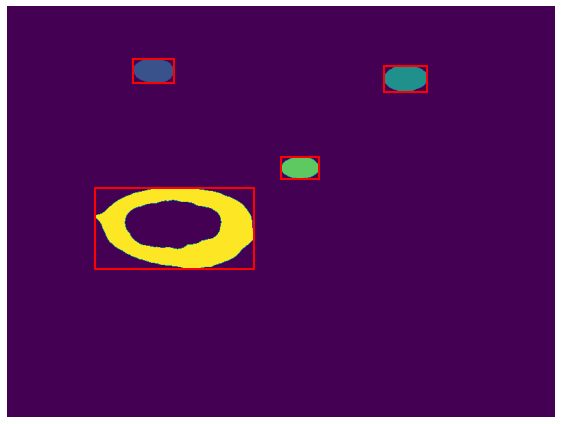

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(segmented)

for region in regionprops(segmented):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

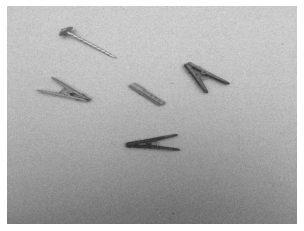

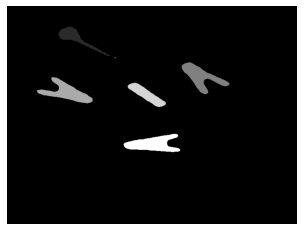

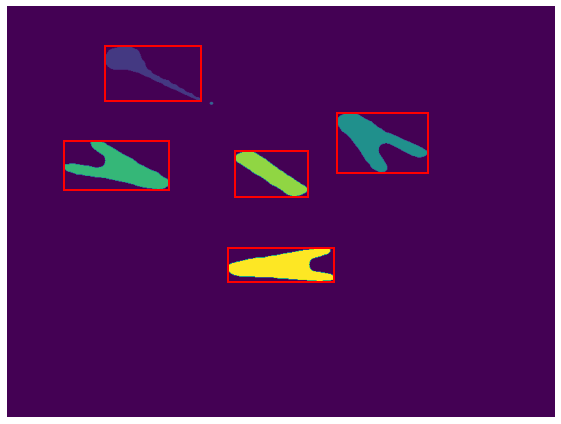

In [83]:
index=13
EQUA = exposure.equalize_adapthist(lista_fotos[index], clip_limit=0.03)
thresh=0.3

f = EQUA
binary_f = f > thresh
binary_f = ~binary_f

blurred_f = ndimage.gaussian_filter(f, 3)
binary_blurred_f = blurred_f > thresh
binary_blurred_f = ~binary_blurred_f
footprint = disk(10)
limp = closing(binary_blurred_f,footprint)*255
img = limp
img_shape = img.shape
no_borders = clear_border(limp)

regions, n_regions = label(no_borders,return_num = True,connectivity= None)

plt.imshow(lista_fotos[index], cmap = "gray")
plt.axis('off')
plt.show()

plt.imshow(regions, cmap = "gray")
plt.axis('off')
plt.show()

props = regionprops(regions)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(regions)

for region in regionprops(regions):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()


Se necesita que el footplrit de closing sea 10 xq sino puede que una objetos que esten cerca

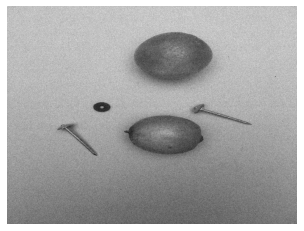

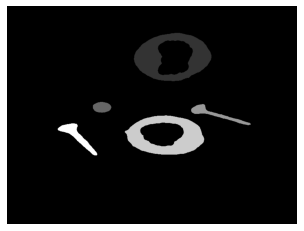

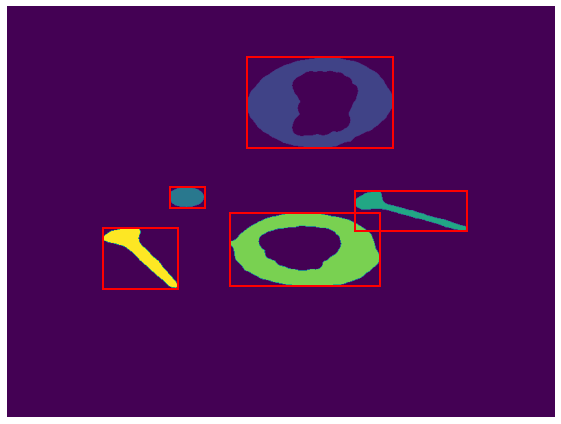

In [82]:
index=12
EQUA = exposure.equalize_adapthist(lista_fotos[index], clip_limit=0.03)
thresh=0.3

f = EQUA
binary_f = f > thresh
binary_f = ~binary_f

blurred_f = ndimage.gaussian_filter(f, 3)
binary_blurred_f = blurred_f > thresh
binary_blurred_f = ~binary_blurred_f
footprint = disk(10)
limp = closing(binary_blurred_f,footprint)*255
img = limp
img_shape = img.shape
no_borders = clear_border(limp)

regions, n_regions = label(no_borders,return_num = True,connectivity= None)

plt.imshow(lista_fotos[index], cmap = "gray")
plt.axis('off')
plt.show()

plt.imshow(regions, cmap = "gray")
plt.axis('off')
plt.show()

props = regionprops(regions)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(regions)

for region in regionprops(regions):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

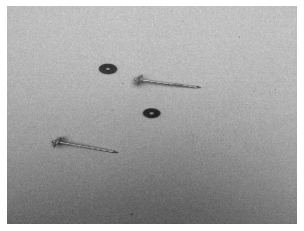

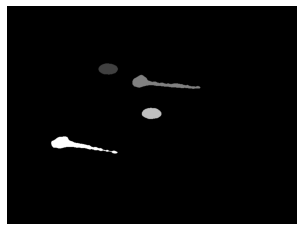

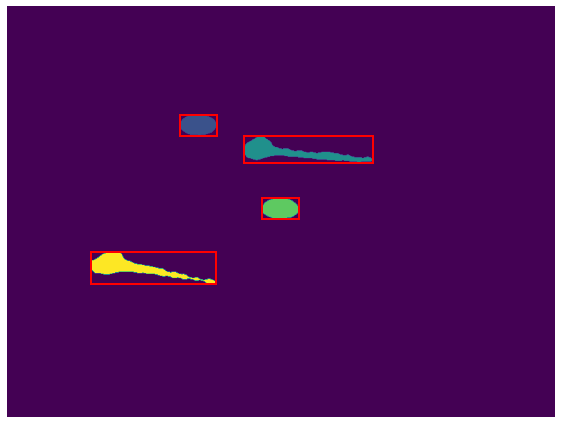

In [101]:
index=5
EQUA = exposure.equalize_adapthist(lista_fotos[index], clip_limit=0.03)
thresh=0.3

f = EQUA
binary_f = f > thresh
binary_f = ~binary_f

blurred_f = ndimage.gaussian_filter(f, 3)
binary_blurred_f = blurred_f > thresh
binary_blurred_f = ~binary_blurred_f
footprint = disk(10)
limp = closing(binary_blurred_f,footprint)*255
img = limp
img_shape = img.shape
no_borders = clear_border(limp)

regions, n_regions = label(no_borders,return_num = True,connectivity= None)

plt.imshow(lista_fotos[index], cmap = "gray")
plt.axis('off')
plt.show()

plt.imshow(regions, cmap = "gray")
plt.axis('off')
plt.show()

props = regionprops(regions)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(regions)

for region in props:
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [98]:
for region in props:
    # take regions with large enough areas
    if region.area >= 100:
        print(region.orientation*180/np.pi)
        print(region.centroid)

89.44491212821087
(172.97832817337462, 278.48993808049534)
83.99059060261926
(213.18832236842104, 414.2890625)
89.37099923391395
(295.27684049079755, 398.39187116564415)
80.71948564553611
(381.30543078807676, 182.248264597795)


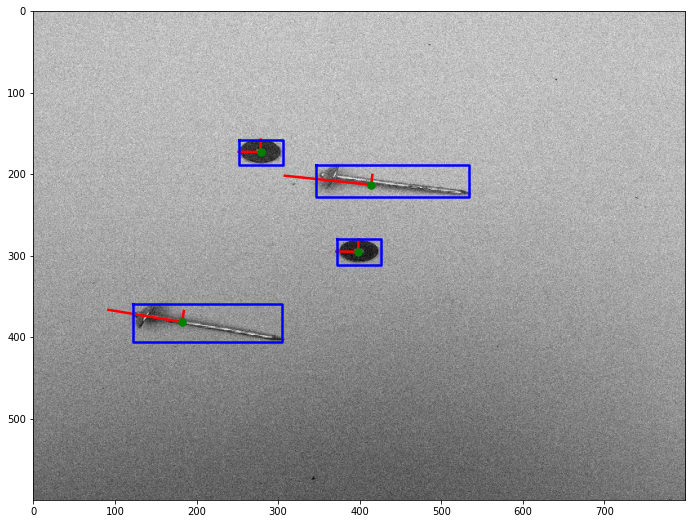

In [105]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.imshow(lista_fotos[index], cmap=plt.cm.gray)

for prop in props:
    y0, x0 = prop.centroid
    orientation = prop.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * prop.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * prop.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * prop.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * prop.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = prop.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

#ax.axis((0, 600, 600, 0))
plt.show()